Testing environment:
python 3.11.7
numpy 1.26.4
pandas 2.1.4
scikit-learn 1.2.2
matplotlib 3.8.0

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.tsa.seasonal import STL

from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

Define functions used in this code

In [5]:
# array shall be a one dimension np array
def arrayStd(array):
    return ((array - np.mean(array))/np.std(array)).astype(float)

def arrayCum(array):
    res = array.copy()
    for i in range(1, array.shape[0]):
        res[i] = res[i - 1] + array[i]
    return res.astype(float)
def arraySmooth(array, n):
    t = np.append(np.ones(n), np.append(array, np.ones(n)))
    res = array.copy()
    for i in range(res.shape[0]):
        res[i] = np.mean(t[i:(i + 2*n +1)])
    return res.astype(float)

def perfMetric(y_true, y_pred):
    r2 = metrics.r2_score(y_true, y_pred)
    cc = np.corrcoef(y_true, y_pred)[0, 1]
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    return np.array([r2, cc, rmse])

Import data for the water balance model

In [6]:
rawinput = pd.read_excel('./input_waterBalanceModel.xlsx').values[:, 1:]

# average groundwater depth in unconfined aquifers in the Haihe River basin
depth = rawinput[:, 0]
stdDepth = np.std(depth)
meanDepth = np.mean(depth)

# precipitation
pr = rawinput[:, 1]
prC = arrayCum(pr)
# irrigation water
iw = rawinput[:, 2]
iwC = arrayCum(iw)
iwsmooth = arraySmooth(iw, 1)
iwCsmooth = arrayCum(iwsmooth)
# south-to-north water diversion
wad = rawinput[:, 3]
wadC = arrayCum(wad)
# precipitation lag 1 month
pr1 = rawinput[:, 4]
pr1C = arrayCum(pr1)
# precipitation lag 2 month
pr2 = rawinput[:, 5]
pr2C = arrayCum(pr2)
# precipitation lag 3 month
pr3 = rawinput[:, 6]
pr3C = arrayCum(pr3)
# precipitation lag 4 month
pr4 = rawinput[:, 7]
pr4C = arrayCum(pr4)

month_start = np.datetime64('2005-01')
month_end = np.datetime64('2024-01')
timeseries = np.arange(month_start, month_end)

Use different factors to fit the observed groundwater depth

In [11]:
Yselected = -depth.astype(np.float64)
constC = np.arange(228)

# 70% of the samples for training and the other 30% for testing
splitThres = 0.3
# randomly train and test 10,000 times
numLoop = 10000

# choose your factors
# for example, we choose Pr_lag2, IWU, and Div from the input excel file
Xselected = np.array([pr2C, iwC, wadC]).T
# matrix recording the result of every run
perfLoop = np.zeros((numLoop, 6))

for i in range(numLoop):
    trainMask = np.random.rand(Yselected.shape[0]) > splitThres
    X_train = Xselected[trainMask, :]
    Y_train = Yselected[trainMask]
    X_test = Xselected[~trainMask, :]
    Y_test = Yselected[~trainMask]

    ols = LinearRegression()
    ols.fit(X_train, Y_train)
    y_train = ols.predict(X_train)
    
    perf_train = perfMetric(Y_train, y_train)
    perfLoop[i, 0:3] = perf_train

    if len(X_test) > 0:
        y_test = ols.predict(X_test)
        perf_test = perfMetric(Y_test, y_test)
        perfLoop[i, 3:6] = perf_test

print('Training R2 = ', np.mean(perfLoop, axis=0)[0], \
      '\nTraining RMSE (m) = ', np.mean(perfLoop, axis=0)[2], \
        '\nTesting R2 = ', np.mean(perfLoop, axis=0)[3], \
           '\nTesting RMSE (m) = ', np.mean(perfLoop, axis=0)[5] )

Training R2 =  0.9176885917127622 
Training RMSE (m) =  0.5928788370826391 
Testing R2 =  0.9104880187910943 
Testing RMSE (m) =  0.6087881569536043


In [14]:
# replace some of the inputs to random

# 70% of the samples for training and the other 30% for testing
splitThres = 0.3
# randomly train and test 10,000 times
numLoop = 10000
# matrix recording the result of every run
perfLoop_random = np.zeros((numLoop, 6))
for i in range(numLoop):
    randSeriesC = arrayCum(np.random.rand(Yselected.shape[0]))
    # replace a factor with random input
    # for example, we choose Pr_lag2, IWU, and RANDOM
    Xselected = np.array([pr2C, iwC, randSeriesC]).T
    
    trainMask = np.random.rand(Yselected.shape[0]) > splitThres
    X_train = Xselected[trainMask, :]
    Y_train = Yselected[trainMask]
    X_test = Xselected[~trainMask, :]
    Y_test = Yselected[~trainMask]

    ols = LinearRegression()
    ols.fit(X_train, Y_train)
    y_train = ols.predict(X_train)

    perf_train = perfMetric(Y_train, y_train)
    perfLoop_random[i, 0:3] = perf_train
    if len(X_test) > 0:
        y_test = ols.predict(X_test)
        perf_test = perfMetric(Y_test, y_test)
        perfLoop_random[i, 3:6] = perf_test

print('Training R2 = ', np.mean(perfLoop_random, axis=0)[0], \
      '\nTraining RMSE (m) = ', np.mean(perfLoop_random, axis=0)[2], \
        '\nTesting R2 = ', np.mean(perfLoop_random, axis=0)[3], \
           '\nTesting RMSE (m) = ', np.mean(perfLoop_random, axis=0)[5] )

Training R2 =  0.8526224052687857 
Training RMSE (m) =  0.7899188335252919 
Testing R2 =  0.8414004828722449 
Testing RMSE (m) =  0.8066830581759111


Plot groundwater depth under different scenarios with confidence intervals
The plotted figure is the draft for Fig. 4

Text(0.0, 1.0, '(b)')

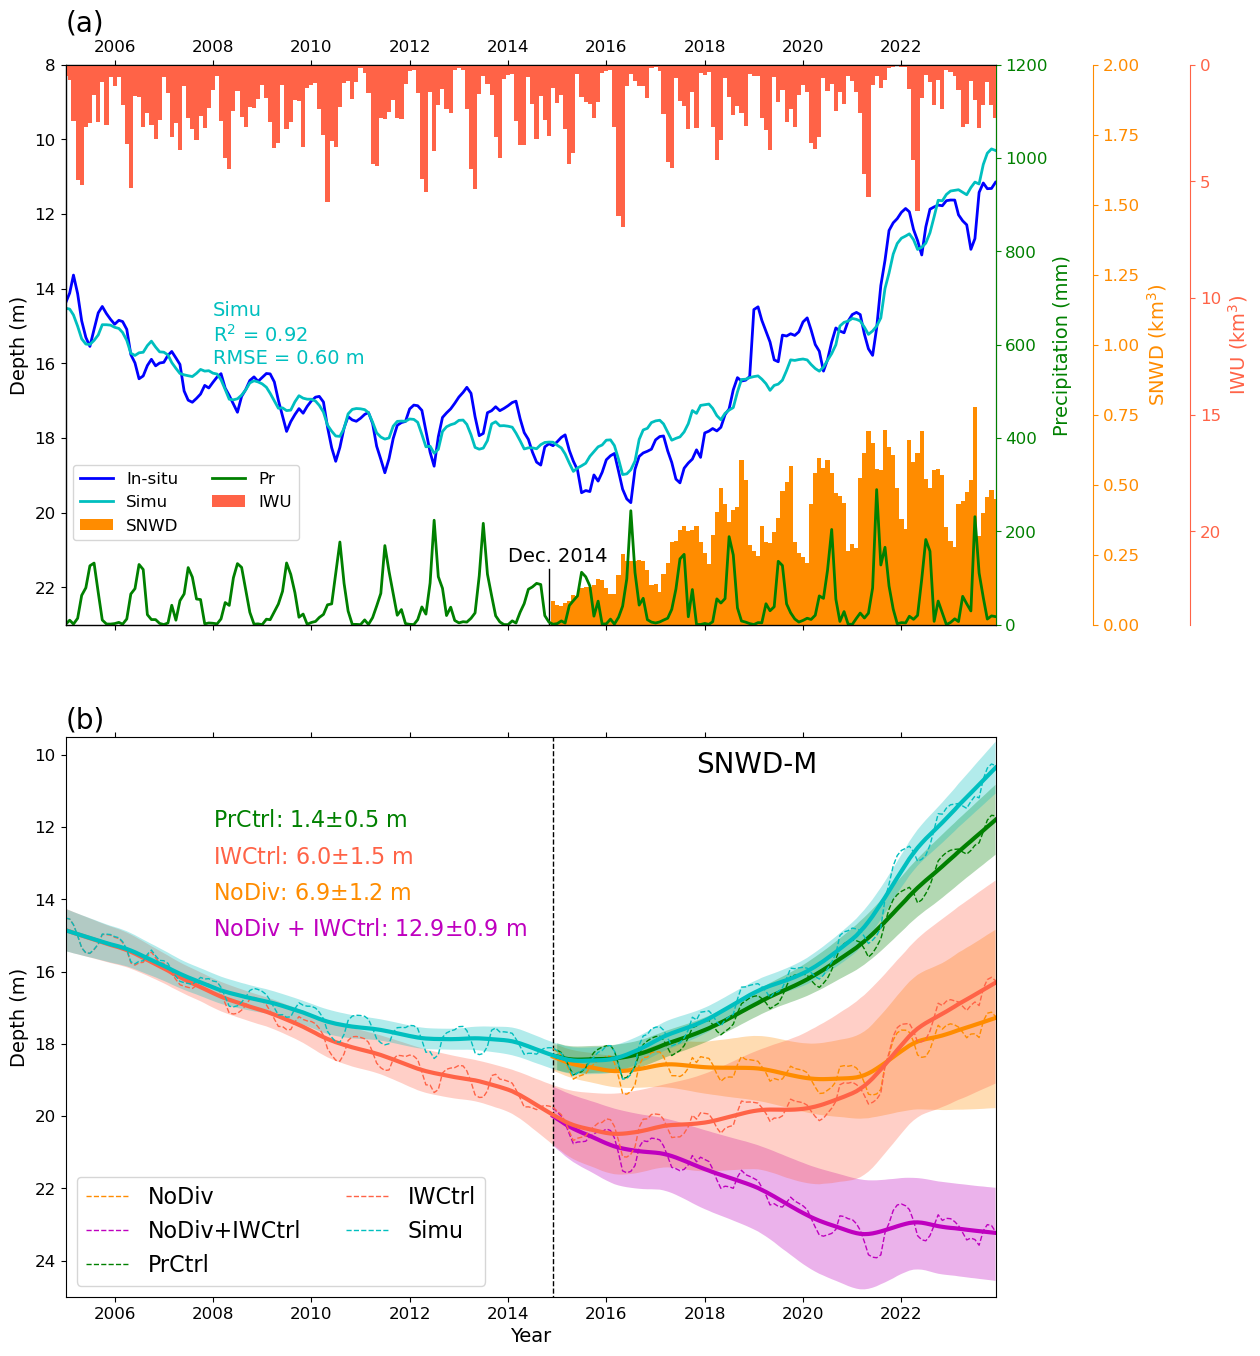

In [12]:
Yselected = -depth.astype(np.float64)
constC = np.arange(228)
Xselected = np.array([pr2C, iwC, wadC]).T

ols = LinearRegression()
ols.fit(Xselected, Yselected)
y_fit = ols.predict(Xselected)

coef = ols.coef_
intercept = ols.intercept_

# STL decomposition
y_fit_STL = STL(y_fit, period=12).fit()
y_fit_Trend = y_fit_STL.trend

depth_STL = STL(depth, period=12).fit()
depth_Trend = depth_STL.trend

# No South-to-North Water Diversion (NoDiv)
X_NoDiv = np.array([pr2C, iwC, np.zeros(depth.shape[0])]).T
y_NoDiv = np.matmul(X_NoDiv, coef) + intercept
y_NoDiv_STL = STL(y_NoDiv, period=12).fit()
y_NoDiv_Trend = y_NoDiv_STL.trend

# Precipition from 2015-2022 set to be the average of 2005-2014 (PrCtrl)
pr_raw = pr2.copy()
pr_avg_bf14 = np.mean(pr_raw[0:120].reshape(10, 12), axis=0)
pr_cali = np.append(pr_raw[0:120], np.tile(pr_avg_bf14, 9))
prC_cali = arrayCum(pr_cali)
X_Prcali = np.array([prC_cali, iwC, wadC]).T
y_Prcali = np.matmul(X_Prcali, coef) + intercept
y_PrCali_STL = STL(y_Prcali, period=12).fit()
y_PrCali_Trend = y_PrCali_STL.trend

# Remove the linear decreasing trend of IWU (IrrCtrl)
iw_raw = iw.copy()
ols_iw = LinearRegression()
ols_iw.fit(np.arange(len(iw_raw)).reshape(-1, 1), iw_raw)
iw_cali = iw_raw + (-ols_iw.coef_)*np.arange(228)
iwC_cali = arrayCum(iw_cali)
X_IWcali = np.array([pr2C, iwC_cali, wadC]).T
y_IWcali = np.matmul(X_IWcali, coef) + intercept
y_IWCali_STL = STL(y_IWcali, period=12).fit()
y_IWCali_Trend = y_IWCali_STL.trend

# No South-to-North Water Diversion & Remove the linear decreasing trend of IWU (NoDiv+IrrCtrl)
X_old = np.array([pr2C, iwC_cali, np.zeros(depth.shape[0])]).T
y_old = np.matmul(X_old, coef) + intercept
y_OldCali_STL = STL(y_old, period=12).fit()
y_OldCali_Trend = y_OldCali_STL.trend

# estimate confidence intervals
# add random error (Gaussian distribution) to all inputs
numLoop = 10000 # perform the Monte Carlo simulation 10,000 times
sigmaThres = 0.1 # sigma of the Gaussian random error
ciThres = 0.05 #confidence interval of the shade

resFit = np.zeros((depth.shape[0], numLoop))
resNoDiv = np.zeros((depth.shape[0], numLoop))
resPrCali = np.zeros((depth.shape[0], numLoop))
resIWCali = np.zeros((depth.shape[0], numLoop))
resOldCali = np.zeros((depth.shape[0], numLoop))

for i in range(numLoop):
    Y_r = np.minimum(0, Yselected + np.random.randn(pr2.shape[0])*sigmaThres*np.nanmedian(Yselected))
    pr_r = np.maximum(0, pr2 + np.random.randn(pr2.shape[0])*sigmaThres*np.nanmedian(pr2))
    iw_r = np.maximum(0, iw + np.random.randn(pr2.shape[0])*sigmaThres*np.nanmedian(iw))
    wad_r = np.maximum(0, wad + np.random.randn(pr2.shape[0])*sigmaThres*np.nanmedian(wad))
    prC_r = arrayCum(pr_r)
    iwC_r = arrayCum(iw_r)
    wadC_r = arrayCum(wad_r)
    X_r = np.array([prC_r, iwC_r, wadC_r]).T

    ols_r = LinearRegression()
    ols_r.fit(X_r, Y_r)
    y_fit_r = ols_r.predict(X_r)
    coef_r = ols_r.coef_
    intercept_r = ols_r.intercept_
    resFit[:, i] = STL(y_fit_r, period=12).fit().trend

    # No South-to-North Water Diversion
    X_NoDiv_r = np.array([X_r[:, 0], X_r[:, 1], np.zeros(depth.shape[0])]).T
    y_NoDiv_r = np.matmul(X_NoDiv_r, coef_r) + intercept_r
    resNoDiv[:, i] = STL(y_NoDiv_r, period=12).fit().trend

    # Precipition from 2015-2022 set to be the average of 2005-2014
    pr_raw_r = pr_r.copy()
    pr_avg_bf14_r = np.mean(pr_raw_r[0:120].reshape(10, 12), axis=0)
    pr_cali_r = np.append(pr_raw_r[0:120], np.tile(pr_avg_bf14_r, 9))
    prC_cali_r = arrayCum(pr_cali_r)
    X_Prcali_r = np.array([prC_cali_r, X_r[:, 1], X_r[:, 2]]).T
    y_Prcali_r = np.matmul(X_Prcali_r, coef_r) + intercept_r
    resPrCali[:, i] = STL(y_Prcali_r, period=12).fit().trend

    # IW: no declining trend
    iw_raw_r = iw_r.copy()
    ols_iw_r = LinearRegression()
    ols_iw_r.fit(np.arange(len(iw_raw_r)).reshape(-1, 1), iw_raw_r)
    iw_cali_r = iw_raw_r + (-ols_iw_r.coef_)*np.arange(228)
    iwC_cali_r = arrayCum(iw_cali_r)
    X_IWcali_r = np.array([X_r[:, 0], iwC_cali_r, X_r[:, 2]]).T
    y_IWcali_r = np.matmul(X_IWcali_r, coef_r) + intercept_r
    resIWCali[:, i] = STL(y_IWcali_r, period=12).fit().trend

    # No South-to-North Water Diversion & IW: no declining trend
    X_old_r = np.array([X_r[:, 0], iwC_cali_r, np.zeros(depth.shape[0])]).T
    y_old_r = np.matmul(X_old_r, coef_r) + intercept_r
    resOldCali[:, i] = STL(y_old_r, period=12).fit().trend

resFit_sort = resFit.copy()
for i in range(depth.shape[0]):
    resFit_sort[i, :] = np.sort(resFit_sort[i, :])
y_fit_up = resFit_sort[:, np.floor(numLoop*(1 - 0.5*ciThres)).astype(int)]
y_fit_dw = resFit_sort[:, np.ceil(numLoop*(.5*ciThres)).astype(int)]

resNoDiv_sort = resNoDiv.copy()
for i in range(depth.shape[0]):
    resNoDiv_sort[i, :] = np.sort(resNoDiv_sort[i, :])
y_NoDiv_up = resNoDiv_sort[:, np.floor(numLoop*(1 - 0.5*ciThres)).astype(int)]
y_NoDiv_dw = resNoDiv_sort[:, np.ceil(numLoop*(.5*ciThres)).astype(int)]

resPrCali_sort = resPrCali.copy()
for i in range(depth.shape[0]):
    resPrCali_sort[i, :] = np.sort(resPrCali_sort[i, :])
y_PrCali_up = resPrCali_sort[:, np.floor(numLoop*(1 - 0.5*ciThres)).astype(int)]
y_PrCali_dw = resPrCali_sort[:, np.ceil(numLoop*(.5*ciThres)).astype(int)]

resIWCali_sort = resIWCali.copy()
for i in range(depth.shape[0]):
    resIWCali_sort[i, :] = np.sort(resIWCali_sort[i, :])
y_IWCali_up = resIWCali_sort[:, np.floor(numLoop*(1 - 0.5*ciThres)).astype(int)]
y_IWCali_dw = resIWCali_sort[:, np.ceil(numLoop*(.5*ciThres)).astype(int)]

resOld_sort = resOldCali.copy()
for i in range(depth.shape[0]):
    resOld_sort[i, :] = np.sort(resOld_sort[i, :])
y_OldCali_up = resOld_sort[:, np.floor(numLoop*(1 - 0.5*ciThres)).astype(int)]
y_OldCali_dw = resOld_sort[:, np.ceil(numLoop*(.5*ciThres)).astype(int)]

#-----------------------------------------------------------------------------------------------
# visualize

fig, [ax1, ax9] = plt.subplots(2, 1, figsize = (12, 16))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax2.spines['right'].set_position(('outward', 70))
ax4.spines['right'].set_position(('outward', 140))

q11, = ax1.plot(timeseries, depth ,'b', linewidth = 2)
q13, = ax1.plot(timeseries, -y_fit, 'c', linewidth = 2)
ax1.plot([np.datetime64('2014-11'), np.datetime64('2014-11')], [21.5, 23.5], 'k', linewidth = 1)
ax1.set_xlim([np.datetime64('2005-01'), np.datetime64('2023-12')])
ax1.set_ylim([8, 23])
ax1.invert_yaxis()
ax1.set_ylabel('Depth (m)', fontsize=14)

c2 = 'darkorange'
q21 = ax2.bar(timeseries, wad*0.128, width=np.timedelta64(1, 'M'), color=c2)
ax2.set_ylim([0, 2])
ax2.tick_params(color=c2, labelcolor=c2)
ax2.spines['right'].set_color(c2)
ax2.set_ylabel('SNWD (km$^3$)', c=c2, fontsize=14)

c3 = 'g'
q31, = ax3.plot(timeseries, pr, c3, linewidth = 2)
ax3.set_ylim([0, 1200])
ax3.tick_params(color=c3, labelcolor=c3)
ax3.spines['right'].set_color(c3)
ax3.set_ylabel('Precipitation (mm)', c=c3, fontsize=14)

c4 = 'tomato'
q41 = ax4.bar(timeseries, iw*0.318, width=np.timedelta64(1, 'M'), color=c4)
ax4.set_ylim([0, 24])
ax4.tick_params(color=c4, labelcolor=c4)
ax4.spines['right'].set_color(c4)
ax4.set_ylabel('IWU (km$^3$)', c=c4, fontsize=14)
ax4.invert_yaxis()

ax1.text(np.datetime64('2014-01'), 21.3, 'Dec. 2014', fontsize=14)
ax1.text(np.datetime64('2008-01'), 16, 'Simu\nR$^2$ = 0.92\nRMSE = 0.60 m', c='c', fontsize=14)

ax1.legend([q11, q13, q21, q31, q41], ['In-situ', 'Simu', 'SNWD', 'Pr', 'IWU'], \
           fontsize=12,  ncol = 2, bbox_to_anchor=[.26, .30])
ax1.set_title('(a)', fontsize=20, loc='left')


ax1.tick_params(labelsize=12, top=True, labeltop=True, bottom=True, labelbottom=False)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)
ax4.tick_params(labelsize=12)

p0, = ax9.plot([np.datetime64('2014-12'), np.datetime64('2014-12')], [5, 30], '--k', linewidth = 1)

p11, = ax9.plot(timeseries[119:], -y_NoDiv[119:], '--', c=c2, linewidth = 1)
p13 = ax9.fill_between(timeseries[119:], -y_NoDiv_dw[119:], -y_NoDiv_up[119:], facecolor=c2, alpha=.3)
p12, = ax9.plot(timeseries[119:], -y_NoDiv_Trend[119:], c=c2, linewidth = 3)

p21, = ax9.plot(timeseries[119:], -y_old[119:], '--m', linewidth = 1)
p23 = ax9.fill_between(timeseries[119:], -y_OldCali_dw[119:], -y_OldCali_up[119:], facecolor='m', alpha=.3)
p22, = ax9.plot(timeseries[119:], -y_OldCali_Trend[119:], 'm', linewidth = 3)

p31, = ax9.plot(timeseries[120:], -y_Prcali[120:], '--', c=c3, linewidth = 1)
p33 = ax9.fill_between(timeseries[120:], -y_PrCali_dw[120:], -y_PrCali_up[120:], facecolor=c3, alpha=.3)
p32, = ax9.plot(timeseries[120:], -y_PrCali_Trend[120:], c=c3, linewidth = 3)

p41, = ax9.plot(timeseries, -y_IWcali, '--', c=c4, linewidth = 1)
p43 = ax9.fill_between(timeseries, -y_IWCali_dw, -y_IWCali_up, facecolor=c4, alpha=.3)
p42, = ax9.plot(timeseries, -y_IWCali_Trend, c=c4, linewidth = 3)

p51, = ax9.plot(timeseries, -y_fit, '--c', linewidth = 1)
p53 = ax9.fill_between(timeseries, -y_fit_dw, -y_fit_up, facecolor='c', alpha=.3)
p52, = ax9.plot(timeseries, -y_fit_Trend, 'c', linewidth = 3)

ax9.legend([p11, p21, p31, p41, p51], \
           ['NoDiv', 'NoDiv+IWCtrl', 'PrCtrl', 'IWCtrl', 'Simu'], \
            fontsize=16,  ncol = 2, loc='lower left')
ax9.set_xlim([np.datetime64('2005-01'), np.datetime64('2023-12')])
ax9.set_ylim([9.5, 25])
ax9.tick_params(labelsize=12, top=True)
ax9.set_xlabel('Year', fontsize=14)
ax9.set_ylabel('Depth (m)', fontsize=14)
ax9.text(np.datetime64('2017-11'), 10.5, 'SNWD-M', fontsize=20)
ax9.text(np.datetime64('2008-01'), 12, "PrCtrl: " + "{0:.1f}".format(y_fit_Trend[-1]-y_PrCali_Trend[-1]) + "$\pm$" +\
         "{0:.1f}".format(np.sqrt(np.var(resFit[-1, :]-resPrCali[-1, :]))) + " m",  c=c3, fontsize=16)
ax9.text(np.datetime64('2008-01'), 13, "IWCtrl: " + "{0:.1f}".format(y_fit_Trend[-1]-y_IWCali_Trend[-1]) + "$\pm$" +\
         "{0:.1f}".format(np.sqrt(np.var(resFit[-1, :]-resIWCali[-1, :]))) + " m",  c=c4, fontsize=16)
ax9.text(np.datetime64('2008-01'), 14, "NoDiv: " + "{0:.1f}".format(y_fit_Trend[-1]-y_NoDiv_Trend[-1]) + "$\pm$" +\
         "{0:.1f}".format(np.sqrt(np.var(resFit[-1, :]-resNoDiv[-1, :]))) + " m",  c=c2, fontsize=16)
ax9.text(np.datetime64('2008-01'), 15, "NoDiv + IWCtrl: " + "{0:.1f}".format(y_fit_Trend[-1]-y_OldCali_Trend[-1]) + "$\pm$" +\
         "{0:.1f}".format(np.sqrt(np.var(resFit[-1, :]-resOldCali[-1, :]))) + " m",  c='m', fontsize=16)
ax9.invert_yaxis()
ax9.set_title('(b)', fontsize=20, loc='left')